# WBS Classifier – User Guide
*(generated 2025-07-30)*

This interactive notebook walks you through the **Work‑Breakdown‑Structure (WBS) text classifier** project. You'll verify your environment, explore the data, and learn how to train and evaluate three neural‑network architectures (Text‑CNN, LSTM‑RNN, GRU‑RNN) that assign each cost‑line description to one of eight cost categories.

## 1 Verify your setup
Run the next cell to confirm that:
1. Python and key libraries are installed with the **correct versions** as listed in `requirements.txt`.
2. A CUDA‑capable **GPU** is available (optional but recommended).

If anything is missing or mismatched, the cell will print a warning so you can update your environment.

In [1]:
import sys, os, pkg_resources, subprocess, json, platform, importlib.util, textwrap, pathlib
from pathlib import Path

# Resolve the project root (parent of this notebooks/ folder)
PROJECT_ROOT = pathlib.Path(os.getcwd()).resolve().parents[0]  # <- works as long as notebook is in notebooks/  

# 1.  Make it the working dir so all relative paths start here
os.chdir(PROJECT_ROOT)

# 2.  Put `src/` on PYTHONPATH so `import src.xxx` always works
sys.path.append(str(PROJECT_ROOT / "src"))

print("✅ Project root set to:", PROJECT_ROOT)
print("cwd:", Path.cwd())
print("requirements exists:", Path("requirements.txt").exists())
print("dataset exists:", Path("data/raw/wbs_data.csv").exists())

print(f"Python version : {sys.version.split()[0]}")
try:
    import torch
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available : {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA device   : {torch.cuda.get_device_name(0)}")
except ImportError:
    print('⚠️  PyTorch not installed')

# Compare installed packages with requirements.txt
req_path = Path('requirements.txt')
if req_path.exists():
    reqs = [line.strip() for line in req_path.read_text().splitlines() if line.strip() and not line.startswith('#')]
    missing, mismatched = [], []
    for spec in reqs:
        if '==' in spec:
            name, ver = spec.split('==')
        else:
            name, ver = spec, None
        try:
            inst_ver = pkg_resources.get_distribution(name).version
            if ver and inst_ver != ver:
                mismatched.append((name, ver, inst_ver))
        except pkg_resources.DistributionNotFound:
            missing.append(spec)
    if not missing and not mismatched:
        print('✅ All requirements satisfied.')
    else:
        if missing:
            print('\n⚠️  Missing packages:')
            for m in missing:
                print('   ', m)
        if mismatched:
            print('\n⚠️  Version mismatches:')
            for name, exp, got in mismatched:
                print(f'   {name}: expected {exp}, found {got}')
else:
    print('requirements.txt not found – skipping package check.')

✅ Project root set to: C:\Users\cameron.webster\Python\wbs_classifier
cwd: C:\Users\cameron.webster\Python\wbs_classifier
requirements exists: True
dataset exists: True
Python version : 3.11.3
PyTorch version: 2.2.0+cu118
CUDA available : True
CUDA device   : NVIDIA RTX 3500 Ada Generation Laptop GPU
✅ All requirements satisfied.


## 2 Load the WBS data
For security reasons the production dataset isn't bundled with the repository. Place your **raw CSV** under `data/raw/` (default name: `wbs_data.csv`) with at least these columns:
- `wbs_name` – the free‑text description \(input feature\)
- `level_1` – the numeric **target label** (0‑7) matching the eight cost categories

The next cell loads the CSV and shows a quick preview so you can confirm the schema.

In [2]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
RAW_CSV = Path('data/raw/wbs_data.csv')
print(RAW_CSV)
if not RAW_CSV.exists():
    raise FileNotFoundError('Expected data/raw/wbs_data.csv – please add your dataset.')
df = pd.read_csv(RAW_CSV)
print('Shape:', df.shape)
df.head()

data\raw\wbs_data.csv
Shape: (26904, 7)


,project_id,wbs,wbs_name_raw,wbs_name_search_strings,identified_keywords,level_1,wbs_name
0,389,1,SWPF Project,swpf project,NaN,Unmapped,swpf project
1,389,2.1,Design,design,NaN,Unmapped,design
2,389,2.1.0,Enhanced Conceptual Design (ECD),enhanced conceptual design ecd || design,'conceptual design',Design and NRE,enhanced conceptual design ecd design
3,389,2.1.1,Preliminary Design (PD),preliminary design pd || design,'preliminary design',Design and NRE,preliminary design pd design
4,389,2.1.2,Final Design (FD),final design fd || design,'final design',Design and NRE,final design fd design


## 3 Quick EDA – preparing for machine learning
We'll inspect class balance and text length distribution to inform preprocessing choices.

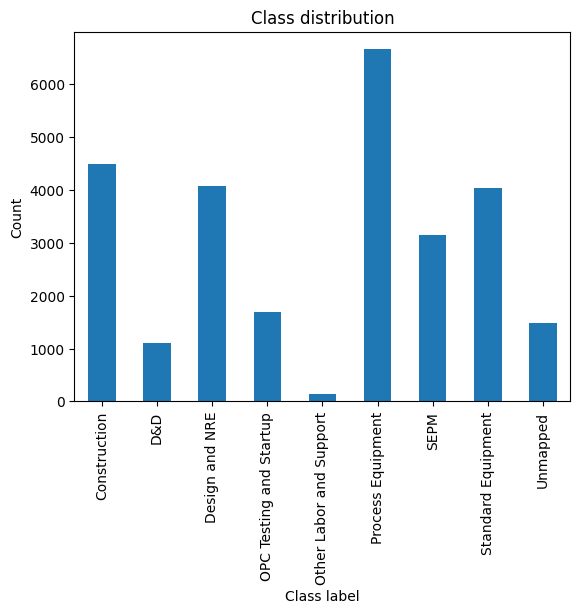

In [3]:
# Class distribution
ax = df['level_1'].value_counts().sort_index().plot(kind='bar')
ax.set_xlabel('Class label')
ax.set_ylabel('Count')
ax.set_title('Class distribution');

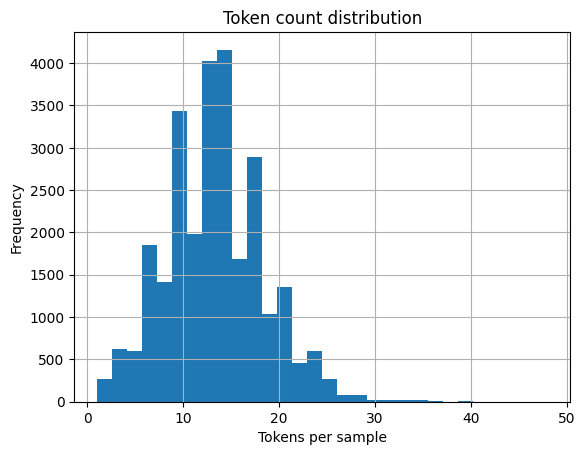

In [4]:
# Text length distribution
df['length'] = df['wbs_name'].astype(str).str.split().str.len()
df['length'].hist(bins=30)
plt.xlabel('Tokens per sample')
plt.ylabel('Frequency')
plt.title('Token count distribution');

## 4 Model architectures & key references
| Model | Paper | Key idea |
|-------|-------|----------|
| **Text‑CNN** | Yoon Kim, *Convolutional Neural Networks for Sentence Classification*, EMNLP 2014 | 1‑D convolutions capture local n‑grams, followed by max‑pooling. |
| **LSTM‑RNN** | Sepp Hochreiter & Jürgen Schmidhuber, *Long Short‑Term Memory*, Neural Computation 1997 | Gated cells mitigate vanishing gradients, enabling long‑range dependency learning. |
| **GRU‑RNN** | Kyunghyun Cho *et al.*, *Learning Phrase Representations using RNN Encoder‑Decoder for Statistical Machine Translation*, EMNLP 2014 | A lighter gated recurrent unit with comparable performance to LSTM. |

All three are implemented in `src/models/` and share a consistent interface.

## 5 Data preprocessing & tokenization
Running `python -m src.data.preprocess` will:
1. **Clean** text (lower‑casing, punctuation stripping, etc.).
2. **Tokenize** with SpaCy (configurable).
3. **Build a vocabulary** of the `N` most‑frequent tokens.
4. **Numericalise** each sample to a fixed‑length tensor (padding/truncation).
5. **Split** into train/val/test sets.

The next cell executes the script so you can inspect artefacts.

In [5]:
import subprocess, sys
print('Preprocessing...')
subprocess.run([sys.executable, '-m', 'src.data.preprocess', '--csv', str(RAW_CSV)], check=True)

Preprocessing...


CompletedProcess(args=['c:\\Users\\cameron.webster\\Python\\wbs_classifier\\.venv\\Scripts\\python.exe', '-m', 'src.data.preprocess', '--csv', 'data\\raw\\wbs_data.csv'], returncode=0)

## 6 Training & evaluation workflow
We'll train each architecture for a **small demo run** (few epochs) so the notebook remains snappy. For real experiments you can bump `Config.EPOCHS` in `src/config.py` or pass `--epochs` on the CLI.


=== Training TEXT_CNN ===

=== Training LSTM_RNN ===

=== Training GRU_RNN ===


Text(0.5, 1.0, 'Loss curves')

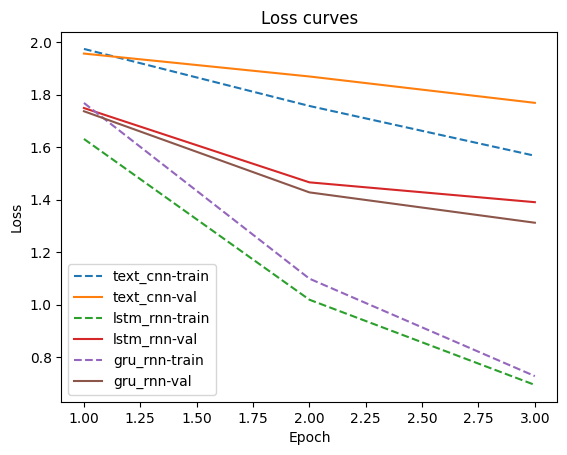

In [6]:
import importlib, json, matplotlib.pyplot as plt, pathlib, sys, subprocess, tempfile, time
ARCHES = ['text_cnn', 'lstm_rnn', 'gru_rnn']
histories = {}
for arch in ARCHES:
    print(f'\n=== Training {arch.upper()} ===')
    res = subprocess.run([
        sys.executable, '-m', 'src.train', '--model_arch', arch, '--epochs', '3', '--batch_size', '256'
    ], check=True)
    # Each run writes training_curves.json -> we move/rename for later plotting
    # metrics_path = pathlib.Path('reports') / 'training_curves.json'
    metrics_path = pathlib.Path("reports/figures") / f"training_curves_{arch}.json"
    if metrics_path.exists():
        with open(metrics_path) as f:
            histories[arch] = json.load(f)
        metrics_path.rename(metrics_path.with_name(f'training_curves_{arch}.json'))

# Plot loss curves
plt.figure()
for arch, hist in histories.items():
    plt.plot(hist['epoch'], hist['train_loss'], label=f'{arch}-train', linestyle='--')
    plt.plot(hist['epoch'], hist['val_loss'], label=f'{arch}-val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss curves')

In [8]:
# Evaluate the best checkpoint of each model on the validation set
for arch in ARCHES:
    print(f'\n=== Evaluating {arch.upper()} ===')
    subprocess.run([
        sys.executable, '-m', 'src.evaluate', '--model_arch', arch, '--split', 'val'
    ], check=True)


=== Evaluating TEXT_CNN ===

=== Evaluating LSTM_RNN ===

=== Evaluating GRU_RNN ===


## 7 Next steps
- Tweak hyper‑parameters in `src/config.py` (embedding size, hidden units, dropout, etc.).
- Add new architectures by subclassing `BaseModel` in `src/models/`.
- Experiment with advanced text representations (word embeddings, transformers).

Happy modeling! 🎉